# Affordance Recognition on the UMD Dataset

This notebook provides a demonstration on inferencing a one-shot affordance recognition model on the __[UMD part-affordance](https://users.umiacs.umd.edu/~fer/affordance/part-affordance-dataset/)__ dataset. You will need to generate a JSON annotation file for the dataset you want to use (refer to the __[README](../README.md/#generating-annotation-files)__ for additional details).


In [1]:
# import standard libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from tqdm import tqdm
torch.manual_seed(1)

# add root code directory to python path
current_dir = os.path.dirname(os.path.abspath(''))
print(f"[INFO] Adding '{current_dir}' to python path.")
sys.path.append(current_dir)

# import libraries from os_tog
import os_tog.model as m
import os_tog.dataset as d
from os_tog.config import AffordanceRecognitionConfig as cfg
from os_tog.utils import visualize, print_losses, visualize_affordances

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

[INFO] Adding 'd:\PhD Projects\OS_TOG (Github)' to python path.


## Loading a Dataset

The code below is used to generate dataset objects and data loaders, as well as preview some affordance annotations from the dataset. This may take ~30s due to the amount of images in the dataset. The second visualization shows an example of how the dataset looks when masked.

In [2]:
# define transformations
def get_transform():
    transforms = []
    transforms.append(d.ToTensor())
    return d.Compose(transforms)

# create dataset objects
test_dataset = d.AffordanceRecognitionDataset(
    cfg.UMD_PATH, 
    annotation_file=os.path.join(cfg.UMD_ANNOT_PATH, "UMD_category_testing_annotations.json"), 
    transforms=get_transform()
)

# create data loaders
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=cfg.TEST_BATCH_SIZE, 
    shuffle=True, # set to true to see varied images or set to False to see them in order 
    num_workers=cfg.NUM_WORKERS, 
    collate_fn=d.collate_fn
)

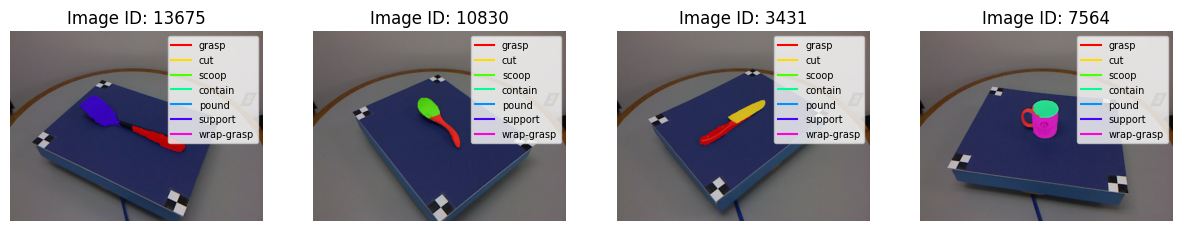

In [3]:
_, ax = plt.subplots(cfg.TEST_BATCH_SIZE//4, 4, figsize=(15, 6))
aff_labels_names = np.array(list(test_dataset.affordance_info.values()))
batch = next(iter(test_loader)) # get batch

for batch_idx in range(len(batch[0])):
    img, target = batch[0][batch_idx], batch[1][batch_idx]
    img = np.array(torchvision.transforms.ToPILImage()(img)) # convert image from tensor to image for plotting
    
    visualize_affordances(
        img, 
        aff_labels=target['affs_labels'][0], 
        aff_labels_names=aff_labels_names , 
        aff_masks=target['affs'][0],
        ax=ax[batch_idx], 
        title=f"Image ID: {target['image_id'].item()}")

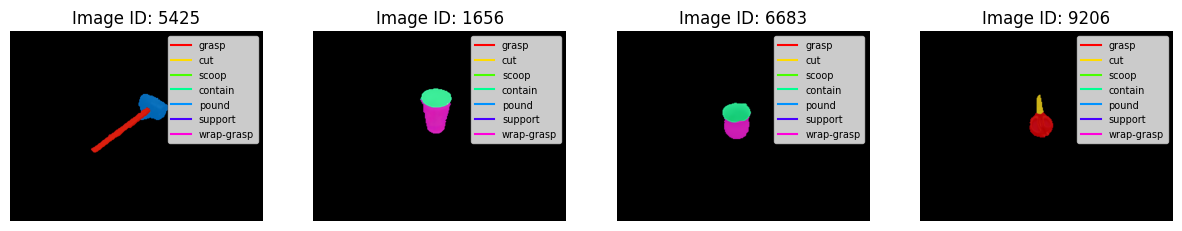

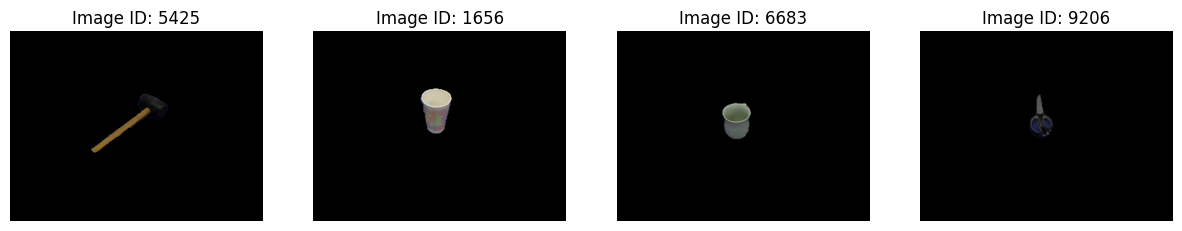

In [4]:
test_dataset.add_mask = True # remove background

# re-create data loader
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=cfg.TEST_BATCH_SIZE, 
    shuffle=True, # set to true to see varied images or set to False to see them in order 
    num_workers=cfg.NUM_WORKERS, 
    collate_fn=d.collate_fn
)

_, ax = plt.subplots(cfg.TEST_BATCH_SIZE//4, 4, figsize=(15, 6))
_, ax2 = plt.subplots(cfg.TEST_BATCH_SIZE//4, 4, figsize=(15, 6))
aff_labels_names = np.array(list(test_dataset.affordance_info.values()))
batch = next(iter(test_loader)) # get batch

for batch_idx in range(len(batch[0])):
    img, target = batch[0][batch_idx], batch[1][batch_idx]
    img = np.array(torchvision.transforms.ToPILImage()(img)) # convert image from tensor to image for plotting
    
    visualize_affordances(
        img, 
        aff_labels=target['affs_labels'][0], 
        aff_labels_names=aff_labels_names , 
        aff_masks=target['affs'][0],
        ax=ax[batch_idx], 
        title=f"Image ID: {target['image_id'].item()}")
    
    visualize(
        img, ax=ax2[batch_idx], title=f"Image ID: {target['image_id'].item()}")

## Inferencing the Model

The code below is used to load the AffCorrs model and inference the model on samples from the test dataset. The code loads a scene from the dataset, a reference image of the object label and shows an example prediction of a chosen affordance.

In [2]:
affordance_model = m.build_affordance_recognition_model(cfg.MODEL_PATH)

Using cache found in C:\Users\vholo/.cache\torch\hub\facebookresearch_dino_main


In [3]:
# define transformations
def get_transform(is_aff_mask=False):
    transforms = []
    if is_aff_mask:
        transforms.append(d.MaskCustomCrop(50, 140, 360)) # (top, left, output)
        transforms.append(torchvision.transforms.ToPILImage())
    else:
        transforms.append(d.ImgCustomCrop([140,50,500,410])) # (x1, y2, x2, y2)
    transforms.append(torchvision.transforms.Resize((256, 256)))
    return torchvision.transforms.Compose(transforms)

# create dataset objects
test_dataset = d.AffordanceRecognitionDataset(
    cfg.UMD_PATH, 
    annotation_file=os.path.join(cfg.UMD_ANNOT_PATH, "UMD_category_testing_annotations.json"), 
    transforms=None
)

Attempting K=10
Using KMeans - PyTorch, Cosine Similarity, No Elbow
Output centroids are normalized
used 4 iterations (0.0099s) to cluster 70 items into 10 clusters
Generating Saliency mask
Attempting K=80
Using KMeans - PyTorch, Cosine Similarity, No Elbow
Output centroids are normalized
used 4 iterations (0.0077s) to cluster 258 items into 80 clusters
Attempting K=80
Using KMeans - PyTorch, Cosine Similarity, No Elbow
Output centroids are normalized
used 8 iterations (0.0105s) to cluster 464 items into 80 clusters
Starting processing of the affordances


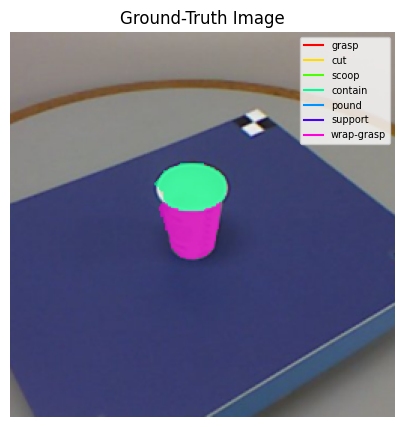

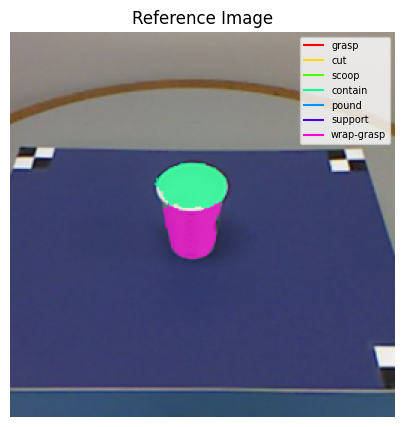

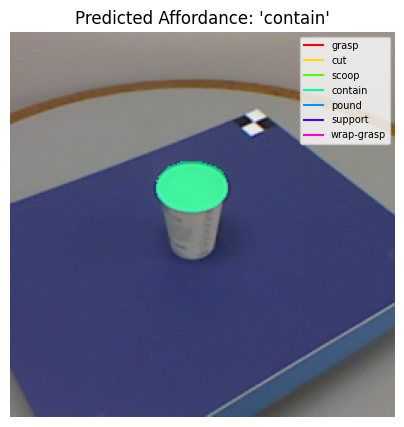

In [6]:
gt_img, gt_target = test_dataset.__getitem__(2000) # load a scene image
aff_labels_names = np.array(list(test_dataset.affordance_info.values()))
img_transforms = get_transform()
aff_transforms = get_transform(is_aff_mask=True)

# visualize ground-truth scene image
gt_img = img_transforms(gt_img) # apply preprocessing
gt_affs = np.array([np.array(aff_transforms(aff.astype(np.uint8))) for aff in gt_target['affs'][0]]) # apply preprocessing
visualize_affordances(np.array(gt_img), aff_labels=gt_target['affs_labels'][0], aff_labels_names=aff_labels_names, aff_masks=gt_affs, figsize=(5,5), title="Ground-Truth Image")

# visualize reference image
ref_img, ref_target = test_dataset.load_reference_image(gt_target['labels'][0].item())
ref_img = img_transforms(ref_img) # apply preprocessing
ref_affs = np.array([np.array(aff_transforms(aff.astype(np.uint8))) for aff in ref_target['affs'][0]]) # apply preprocessing
visualize_affordances(np.array(ref_img), aff_labels=ref_target['affs_labels'][0], aff_labels_names=aff_labels_names, aff_masks=ref_affs, figsize=(5,5), title="Reference Image")

# choose an affordance and get prediction
target_aff = 'contain'
target_aff_mask, target_aff_id = test_dataset.get_reference_affordance_from_image(ref_target, aff_name='contain')
target_affs = np.array(aff_transforms(target_aff_mask.astype(np.uint8)))[None, :, :] # apply preprocessing
pred_affs, _ = m.inference_affordance_recognition_model(affordance_model, ref_img, target_affs, gt_img)
visualize_affordances(np.array(gt_img), aff_labels=np.array([target_aff_id]), aff_labels_names=aff_labels_names, aff_masks=np.array(pred_affs),  figsize=(5,5), title=f"Predicted Affordance: '{target_aff}'")